- Implement GAT

In [1]:
import sys
if 'google.colab' in sys.modules:
  %pip install -q stellargraph[demos]==1.0.0rc1

     |████████████████████████████████| 374 kB 13.9 MB/s 
     |████████████████████████████████| 500 kB 46.6 MB/s 
     |████████████████████████████████| 121 kB 49.1 MB/s 
     |████████████████████████████████| 1.6 MB 46.4 MB/s 
     |████████████████████████████████| 83 kB 487 kB/s 
     |████████████████████████████████| 41 kB 197 kB/s 


In [2]:

# verify that we're using the correct version of StellarGraph for this notebook
import stellargraph as sg

try:
    sg.utils.validate_notebook_version("1.0.0rc1")
except AttributeError:
    raise ValueError(
        f"This notebook requires StellarGraph version 1.0.0rc1, but a different version {sg.__version__} is installed.  Please see <https://github.com/stellargraph/stellargraph/issues/1172>."
    ) from None

In [3]:
import networkx as nx
import pandas as pd
import os

import stellargraph as sg
from stellargraph.mapper import FullBatchNodeGenerator
from stellargraph.layer import GAT

from tensorflow.keras import layers, optimizers, losses, metrics, Model
from sklearn import preprocessing, feature_extraction, model_selection
from stellargraph import datasets
from IPython.display import display, HTML
import matplotlib.pyplot as plt
%matplotlib inline

In [34]:
dataset = datasets.PubMedDiabetes()
display(HTML(dataset.description))
G, node_subjects = dataset.load()

In [35]:
print(G.info())

StellarGraph: Undirected multigraph
 Nodes: 19717, Edges: 44338

 Node types:
  paper: [19717]
    Features: float32 vector, length 500
    Edge types: paper-cites->paper

 Edge types:
    paper-cites->paper: [44338]
        Weights: all 1 (default)


In [36]:
set(node_subjects)

{1, 2, 3}

In [37]:
train_subjects, test_subjects = model_selection.train_test_split(
    node_subjects, train_size=7000, test_size=None, stratify=node_subjects
)
val_subjects, test_subjects = model_selection.train_test_split(
    test_subjects, train_size=3000, test_size=None, stratify=test_subjects
)

In [38]:
from collections import Counter

Counter(train_subjects)

Counter({1: 1457, 2: 2796, 3: 2747})

In [39]:

target_encoding = preprocessing.LabelBinarizer()

train_targets = target_encoding.fit_transform(train_subjects)
val_targets = target_encoding.transform(val_subjects)
test_targets = target_encoding.transform(test_subjects)

In [40]:
generator = FullBatchNodeGenerator(G, method="gat")

In [41]:
train_gen = generator.flow(train_subjects.index, train_targets)

In [75]:
gat = GAT(
    layer_sizes=[8, train_targets.shape[1]],
    activations=["elu", "softmax"],
    attn_heads=8,
    generator=generator,
    in_dropout=0.5,
    attn_dropout=0.5,
    normalize=None,
)

In [76]:
x_inp, predictions = gat.in_out_tensors()

In [77]:

model = Model(inputs=x_inp, outputs=predictions)
model.compile(
    optimizer=optimizers.Adam(learning_rate=0.005),
    loss=losses.categorical_crossentropy,
    metrics=["acc"],
)

In [78]:
val_gen = generator.flow(val_subjects.index, val_targets)

In [79]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

if not os.path.isdir("logs"):
    os.makedirs("logs")
es_callback = EarlyStopping(
    monitor="val_acc", patience=20
)  # patience is the number of epochs to wait before early stopping in case of no further improvement
mc_callback = ModelCheckpoint(
    "logs/best_model.h5", monitor="val_acc", save_best_only=True, save_weights_only=True
)

In [80]:
history = model.fit(
    train_gen,
    epochs=50,
    validation_data=val_gen,
    verbose=2,
    shuffle=False,  # this should be False, since shuffling data means shuffling the whole graph
    callbacks=[es_callback, mc_callback],
)

Epoch 1/50
1/1 - 4s - loss: 1.0976 - acc: 0.3530 - val_loss: 1.0673 - val_acc: 0.5710 - 4s/epoch - 4s/step
Epoch 2/50
1/1 - 0s - loss: 1.0676 - acc: 0.4926 - val_loss: 1.0406 - val_acc: 0.6047 - 413ms/epoch - 413ms/step
Epoch 3/50
1/1 - 0s - loss: 1.0380 - acc: 0.5330 - val_loss: 1.0165 - val_acc: 0.6177 - 403ms/epoch - 403ms/step
Epoch 4/50
1/1 - 0s - loss: 1.0164 - acc: 0.5319 - val_loss: 0.9949 - val_acc: 0.6193 - 410ms/epoch - 410ms/step
Epoch 5/50
1/1 - 0s - loss: 0.9970 - acc: 0.5267 - val_loss: 0.9750 - val_acc: 0.6213 - 412ms/epoch - 412ms/step
Epoch 6/50
1/1 - 0s - loss: 0.9758 - acc: 0.5480 - val_loss: 0.9563 - val_acc: 0.6207 - 379ms/epoch - 379ms/step
Epoch 7/50
1/1 - 0s - loss: 0.9682 - acc: 0.5289 - val_loss: 0.9382 - val_acc: 0.6263 - 433ms/epoch - 433ms/step
Epoch 8/50
1/1 - 0s - loss: 0.9466 - acc: 0.5499 - val_loss: 0.9199 - val_acc: 0.6267 - 403ms/epoch - 403ms/step
Epoch 9/50
1/1 - 0s - loss: 0.9340 - acc: 0.5564 - val_loss: 0.9013 - val_acc: 0.6310 - 404ms/epoch - 

<class 'dict'>


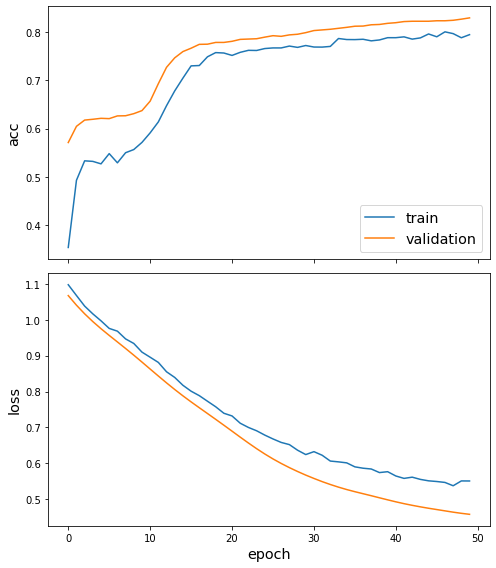

In [81]:
sg.utils.plot_history(history)

In [49]:
model.load_weights("logs/best_model.h5")

In [50]:
test_gen = generator.flow(test_subjects.index, test_targets)

In [51]:
test_metrics = model.evaluate(test_gen)
print("\nTest Set Metrics:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

1/1 [==============================] - 0s 140ms/step - loss: 0.4642 - acc: 0.8308

Test Set Metrics:
	loss: 0.4642
	acc: 0.8308


In [52]:
all_nodes = node_subjects.index
all_gen = generator.flow(all_nodes)
all_predictions = model.predict(all_gen)

1/1 [==============================] - 0s 451ms/step


In [53]:
node_predictions = target_encoding.inverse_transform(all_predictions.squeeze())

In [54]:
df = pd.DataFrame({"Predicted": node_predictions, "True": node_subjects})
df.head(20)

,Predicted,True
pid,,
12187484,1,1
2344352,1,1
14654069,1,1
16443886,2,2
2684155,1,1
15032912,3,1
17988185,3,3
9834350,3,3
16230722,3,3


In [55]:
emb_layer = next(l for l in model.layers if l.name.startswith("graph_attention"))
print(
    "Embedding layer: {}, output shape {}".format(emb_layer.name, emb_layer.output_shape)
)

Embedding layer: graph_attention_sparse_2, output shape (1, 19717, 64)


In [56]:
embedding_model = Model(inputs=x_inp, outputs=emb_layer.output)

In [57]:
emb = embedding_model.predict(all_gen)
emb.shape

1/1 [==============================] - 1s 632ms/step


(1, 19717, 64)

In [58]:

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import pandas as pd
import numpy as np

In [59]:
X = emb.squeeze()
y = np.argmax(target_encoding.transform(node_subjects), axis=1)

In [60]:
if X.shape[1] > 2:
    transform = TSNE  # PCA

    trans = transform(n_components=2)
    emb_transformed = pd.DataFrame(trans.fit_transform(X), index=list(G.nodes()))
    emb_transformed["label"] = y
else:
    emb_transformed = pd.DataFrame(X, index=list(G.nodes()))
    emb_transformed = emb_transformed.rename(columns={"0": 0, "1": 1})
    emb_transformed["label"] = y

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


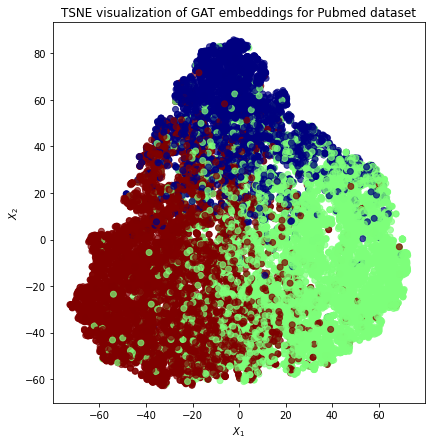

In [62]:
alpha = 0.7

fig, ax = plt.subplots(figsize=(7, 7))
ax.scatter(
    emb_transformed[0],
    emb_transformed[1],
    c=emb_transformed["label"].astype("category"),
    cmap="jet",
    alpha=alpha,
)
ax.set(aspect="equal", xlabel="$X_1$", ylabel="$X_2$")
plt.title(
    "{} visualization of GAT embeddings for Pubmed dataset".format(transform.__name__)
)
plt.show()